# Bowls, A hand controllable gesture based synthesizer
Created using Modal synthesis of tibean drums 
https://www.music.mcgill.ca/~gary/618/week11/node12.html
- 586 Hz - Circulation and Sexuality 
- 492 Hz - Adrenals and Thyroid
- 330 Hz - Kidney 
- 198 Hz - Liver
- 352 Hz - Bladder
- 281.6 Hz - Small Intestine 
- 220 Hz - Lungs 
- 176 Hz - Colon 
- 330 Hz - Gallbladder 
- 117.3 Hz - Pancreas 
- 110 Hz - Stomach 
- 492 Hz - Spleen 

In [244]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from aenum import Enum, skip
import time
import math
import os

# Friction Curves
source: https://www.engineeringtoolbox.com/friction-coefficients-d_778.html
https://engineeringlibrary.org/reference/coefficient-of-friction 

map touch sensor to circle aka sin() -1 to 1

$n$ = each node.

$V_{il}(n)$ and $V_{ir}(n)$ = incoming velocities at the excitation point arriveing from left to right

$V_{h}$ = $\sum_{n}$ $V_{il}(n)$ + $V_{ir}(n)$

In [245]:
class material(Enum):
    @skip
    class aluminum(Enum):
        static = 1.05
        dynamic = 1.4

print(material.aluminum.static.value)


def frictionCurve(static: float, dynamic: float, initial_velocity: float, relative_velocity: float):
    return dynamic + ((static - dynamic) * initial_velocity) / (initial_velocity + relative_velocity)


test = frictionCurve(material.aluminum.static.value, material.aluminum.dynamic.value, 20, 40)
print(test)

1.05
1.2833333333333332


# Digital Wave Guide Filter
y(n) = 2Rcos(theta * y(n - 1)) - R^2y(n - 2) + x(n)
R = e^(-d/FS)
Theta = w / FS
w = 2pi f
FS = Sampling rate

In [246]:
# Truthfully, I don't beileve in healing frequencies. I just thought it would be funny to include
class Aura(Enum):
    Circulation: float = 585
    Adrenals: float = 492
    Thyroid: float = 492
    Kidney: float = 330
    Liver: float = 198
    Bladder : float = 352
    Small_Intestine: float = 281.6
    Lungs: float = 220
    Colon: float = 176
    Gallbladder: float = 330
    Pancreas: float = 117.3
    Stomach: float = 110
    Spleen: float = 492

class wave_guide:
    def __init__(self, N: int):
        self.delay_line = np.zeros(N + 1)
        self.read: int = 1
        self.write: int = 0
        self.delay_length = N + 1

    def process(self, input: float):
        output = self.delay_line[self.read]
        self.delay_line[self.write] = input
        
        self.read = 1 + self.read
        self.write = 1 + self.write

        if self.write >= self.delay_length:
            self.write = 0
        if self.read >= self.delay_length:
            self.read = 0

        return output
    
    def get_output(self):
        return self.delay_line[-1]
    
    def get_delay_len(self):
        return len(self.delay_line)
    
    def get_read(self):
        return self.read
    
    def get_write(self):
        return self.write



class circular_wave_filter:
    # Arguments that don't need inits
    y1: float = 0
    y2: float = 0
    x1: float = 0
    x2: float = 0
    feedback: float = 0
    last_source: float = 0
    l1: float = 0
    l2: float = 0

    # Incoming Velocities Left and Right
    vil: float = 0
    vir: float = 0

    # Outgoing velocities Left and Right

    def __init__(self, samplingRate: float, frequency: float, dampening: float, beats: int):
        # Init all these varibles on creation
        self.sampling_rate = samplingRate
        self.frequency = frequency
        self.dampening = dampening

        # Get the constants for the bp filter
        Bandwidth = 0.5
        R = 1 - (Bandwidth / 2)
        omega = math.cos(self.frequency)
        w = 2 * np.pi * self.frequency
        theta = w / self.sampling_rate
        theta = ((2 * R) / (1 + R*R)) * omega

        self.c2 = (R * R)
        self.c1 = 2 * R * theta
        self.c3 = R


        # Get Freq of waveguides and init
        # Delay Length = Samplerate / Frequency
        # k1: int = round(self.c2 / (freq_one + (self.c1 * freq_one**2)/self.frequency))
        # k2: int = round(self.c2 / (freq_two + (self.c1 * freq_two**2)/self.frequency))
        k1: int = round(self.sampling_rate / (self.frequency + beats))
        k2: int = round(self.sampling_rate / (self.frequency - beats))
        # k1: int = round((self.frequency + beats) / 1000)
        # k2: int = round((self.frequency - beats) / 1000)
        self.Z = k1 + k2
        self.wave_guides = wave_guide(k1)
        print("K1: ", k1, "K2: ", k2)

    # There are faster ways but this works for now
    def __process_bandpass( self, input: float):
        # Process BP filter
        output = self.c1  * self.y1 - self.c2 * self.y2 - self.c3 * self.x2 + input
        self.x2 = self.x1
        self.x1 = input
        self.y2 = self.y1
        self.y1 = output
        return output
        
    def process(self, input: float):
        coupling_constant = 0.0
        self.last_source = 0

        # Create a simple matrix for the outputs
        output_matrix: float = 0
        bandpass_out: float = 0
        source: float = 0
        

        # Set Input
        source = input + self.feedback

        # Get bandpass Outs
        bandpass_out = self.__process_bandpass(source)

        # Get Output
        output_matrix = self.wave_guides.process(bandpass_out)

        # Set Feedback
        self.feedback = output_matrix * coupling_constant



        # Second half of waveguides
        #output_matrix[0,1] = self.l1 = self.wave_guides[0,1].process(bandpass_out)
        # # Bottom Right  
        # self.vir = output_matrix[1,1] = self.wave_guides[1,1].process(output_matrix[0,0])
        # # Bottom Left
        # self.vil = output_matrix[1,0] = self.wave_guides[1,0].process(output_matrix[0,1])
        
        # self.vil = output_matrix[0,1]
        # self.vir = output_matrix[1,1]
        # self.vol = output_matrix[1,0]
        # self.vor = output_matrix[0,0]

        #return [bandpass_out, output_matrix[0,1], output_matrix[1,1]]
        #return bandpass_out
        #mixed_out = output_matrix + output_matrix
        return output_matrix
    
test = circular_wave_filter(44100, 440, 38,2)



K1:  100 K2:  101


In [247]:
# Singing bowls
class singing_bowl_modes:
    def __init__(self, samplingRate: float, frequency: float, dampening: float):
        self.harmonics = np.array([circular_wave_filter(samplingRate, frequency, dampening, 2),
                              circular_wave_filter(samplingRate, frequency * 2, dampening, 5),
                              circular_wave_filter(samplingRate, frequency * 3, dampening, 5),
                              circular_wave_filter(samplingRate, frequency * 4, dampening, 4),
                              ])
        self.amp_values = np.array([0.9, 0.7, 1, 0.8])
    
    def process(self, input: float, debug= False):
        output = 0
        if debug:
            start_time = time.time()
            for i in range(0, len(self.harmonics)):
                output += self.harmonics[i].process(input) * self.amp_values[i]
            print("--- Opened File %s seconds ---" % (time.time() - start_time))
        else:
            for i in range(0, len(self.harmonics)):
                output += self.harmonics[i].process(input) * self.amp_values[i]

        return output

# Test Runner Function


### test1 ###
--- Opened File 0.0007562637329101562 seconds ---
--- File Info 0.005131959915161133 seconds ---
--- Filter 0.014055252075195312 seconds ---


--- Sine Wave 0.8295249938964844 seconds ---
K1:  100 K2:  101
K1:  50 K2:  50
K1:  33 K2:  34
K1:  25 K2:  25
--- Init 0.8297581672668457 seconds ---
--- Process 4.559558153152466 seconds ---
--- Write File 4.563267230987549 seconds ---

### test3 ###
--- Opened File 0.0004899501800537109 seconds ---
--- File Info 0.0019011497497558594 seconds ---
--- Filter 0.00384521484375 seconds ---
--- Sine Wave 0.13605904579162598 seconds ---
K1:  100 K2:  101
K1:  50 K2:  50
K1:  33 K2:  34
K1:  25 K2:  25
--- Init 0.1362018585205078 seconds ---
--- Process 0.9931819438934326 seconds ---
--- Write File 0.995203971862793 seconds ---
K1:  100 K2:  101
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

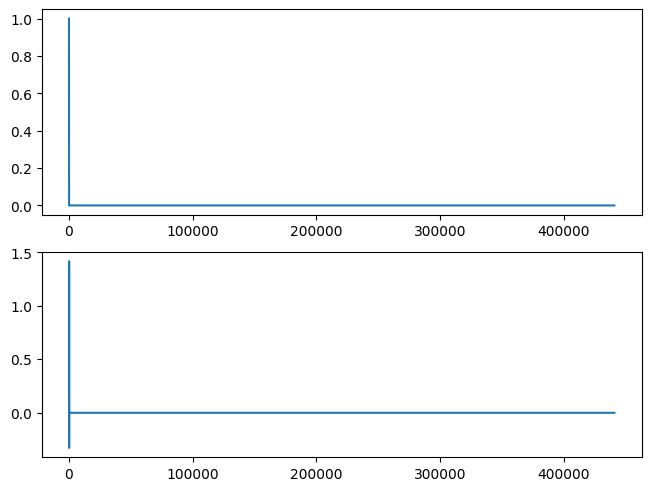

In [248]:
def testRunner(inputFile, outputFileName):
    print()
    print("### {} ###".format(outputFileName))
    start_time = time.time()    
    inputLocation = "imports/" + inputFile
    with sf.SoundFile(inputLocation) as input_file:
        print("--- Opened File %s seconds ---" % (time.time() - start_time))
        y =  np.asarray(input_file.read()) # Read input File
        Fs = input_file.samplerate # Get sample rate
        int_sample = int(Fs)
        fileLength = len(y) # Get length of input file
        fileSec = fileLength / Fs # Get length of input file in seconds
        impulse = np.zeros(fileLength)
        outputSignal = np.zeros(fileLength)
        impulse[1] = 1
        freq = 440

        print("--- File Info %s seconds ---" % (time.time() - start_time))

        sos = signal.butter(2, freq, 'low', fs=Fs, output='sos')
        filtered = signal.sosfilt(sos, y)
        print("--- Filter %s seconds ---" % (time.time() - start_time))
        # sos2 = signal.butter(2, freq, 'high', fs=Fs, output='sos')
        # filtered2 = signal.sosfilt(sos2, filtered)

        sine_wave: float = [(1 - np.cos(2 * np.pi * x / int(Fs))) for x in range(int(Fs * fileSec))]
        y = np.add(0, filtered)
        print("--- Sine Wave %s seconds ---" % (time.time() - start_time))
        newFilter = singing_bowl_modes(Fs, 440, 38)
        print("--- Init %s seconds ---" % (time.time() - start_time))
        for i in range(0, len(y)):
            outputSignal[i] = newFilter.process(y[i])
        print("--- Process %s seconds ---" % (time.time() - start_time))

        #outputSignal = [] # Output signal
        # for i in range(0, len(y)):
        #     outputSignal.append((newout[i]))

        outputLocation = "exports/" + outputFileName +  ".wav"
        sf.write(outputLocation, outputSignal, Fs)
        print("--- Write File %s seconds ---" % (time.time() - start_time))
    return "Successfully Wrote to File"

def internalTestRunner(outputFileName: str, fileSec: int, sampleRate: int, speed: int):
    print()
    print("### {} ###".format(outputFileName))
    sampleTime: any = sampleRate / speed
    impulse = np.zeros(sampleRate)

    valArray = np.rint(np.array([0, sampleTime, sampleTime * 2, sampleTime * 3]))
    numVal = 1
    impulse[0] = numVal
    # impulse[11025] = numVal
    # impulse[11025 * 2] = numVal
    # impulse[11025 * 3] = numVal
    
    # for i in range(0, speed):
    #     currentVal = np.rint(i * sampleTime)
    #     impulse[valArray[i]] = 1

    sine_wave: float = [1 - np.cos(2 * np.pi * x/(sampleRate)) for x in range(sampleRate)]
    fullImpulse = np.tile(impulse, fileSec)
    

    #newFilter = singing_bowl_modes(sampleRate, Aura.Kidney.value, 38)
    newFilter = circular_wave_filter(sampleRate, Aura.Kidney.value, 38, 1)
    outputSignal = np.zeros(len(fullImpulse))
    debug = True
    for i in range(0, len(fullImpulse)):
        if i != 0:
            debug = False            
        outputSignal[i] = newFilter.process(fullImpulse[i]) * 0.00125

    outputLocation = "exports/" + outputFileName +  ".wav"
    sf.write(outputLocation, outputSignal, sampleRate)

def delay_test(outputFileName: str, fileSec: int, sampleRate: int):
    delay_length = round(sampleRate * (fileSec / 2))
    delay_line = circular_wave_filter(sampleRate, 440, 38, 2)
    #print("Ideal Length: ", delay_length, "Real Length: ", delay_line.get_delay_len())
    impulse = np.zeros(sampleRate * fileSec)
    outputSignal = np.zeros(sampleRate * fileSec)
    impulse[0] = 1

    sine_wave: float = [1 - np.cos(2 * np.pi * x/(sampleRate)) for x in range(sampleRate)]

    # for i in range(0, len(sine_wave)):
    #     impulse[i] = sine_wave[i]

    for i in range(0, len(impulse)):
        outputSignal[i] = delay_line.process(impulse[i])
        if i < 10:
            print(outputSignal[i])
        #print(i, "Input: ", impulse[i], "Output: ", outputSignal[i], "read: ", delay_line.get_read())

    outputLocation = "exports/" + outputFileName +  ".wav"
    sf.write(outputLocation, outputSignal, sampleRate)

    fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')
    ax1.plot(impulse)
    ax2.plot(outputSignal)

testRunner("whitenoise.wav", "test1")
testRunner("whitenoise_strike.wav", "test3")
#internalTestRunner("test2", 5, 44100, 4)
delay_test("delay_test", 10, 44100)
